# EDA music

- 모차르트 피아노 협주곡 분석

In [30]:
import numpy as np
import pandas as pd

import os

In [31]:
print(os.listdir("mozart"))

['mz_311_1.mid', 'mz_311_2.mid', 'mz_311_3.mid', 'mz_330_1.mid', 'mz_330_2.mid', 'mz_330_3.mid', 'mz_331_1.mid', 'mz_331_2.mid', 'mz_331_3.mid', 'mz_332_1.mid', 'mz_332_2.mid', 'mz_332_3.mid', 'mz_333_1.mid', 'mz_333_2.mid', 'mz_333_3.mid', 'mz_545_1.mid', 'mz_545_2.mid', 'mz_545_3.mid', 'mz_570_1.mid', 'mz_570_2.mid', 'mz_570_3.mid', 'test_output.mid']


In [48]:
# midi 파일 오픈
from music21 import converter, corpus, instrument, midi, note, chord, pitch, stream, roman

In [15]:
def open_midi(midi_path, remove_drums):
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
midi_file = open_midi("mozart\mz_311_1.mid", True)
midi_file

C:\Users\medici\Anaconda3\lib\site-packages\music21\midi\translate.py:883: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


<music21.stream.Score 0x1731aced610>

In [16]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(midi_file)

Piano right
Piano left


C: 도 ,D: 레 ,E: 미 ,F: 파 ,G: 솔 ,A: 라, B: 시 

<music21.graph.plot.HistogramPitchClass for <music21.stream.Score 0x1731aced610>>

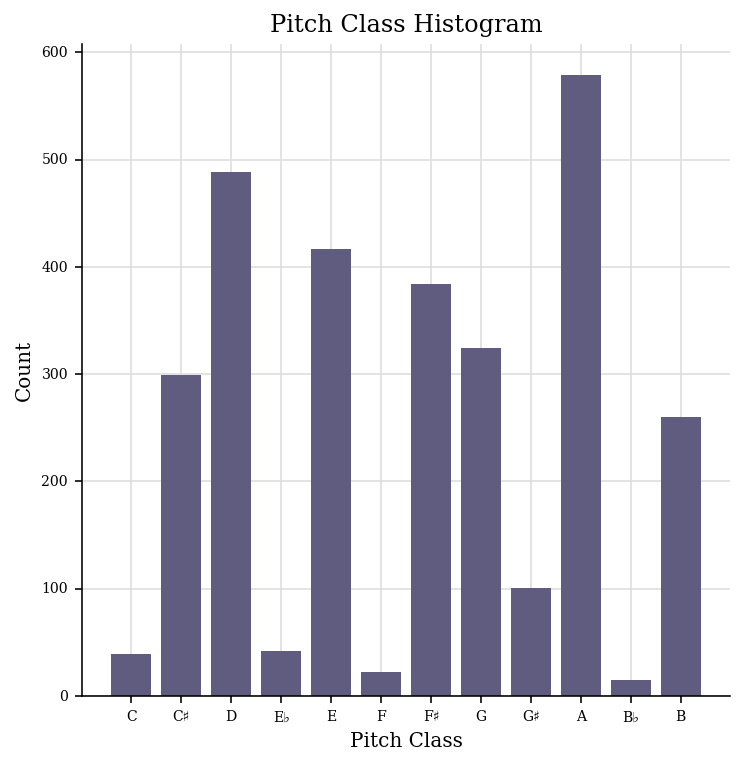

In [17]:
midi_file.plot('histogram', 'pitchClass', 'count')

# C#, D ,E ,F#, G ,A 를 많이 사용  ==> 대체로 밝은 음역대의 음악임을 알수있음

조성 변화 확인

<music21.graph.plot.ScatterPitchClassOffset for <music21.stream.Score 0x1731aced610>>

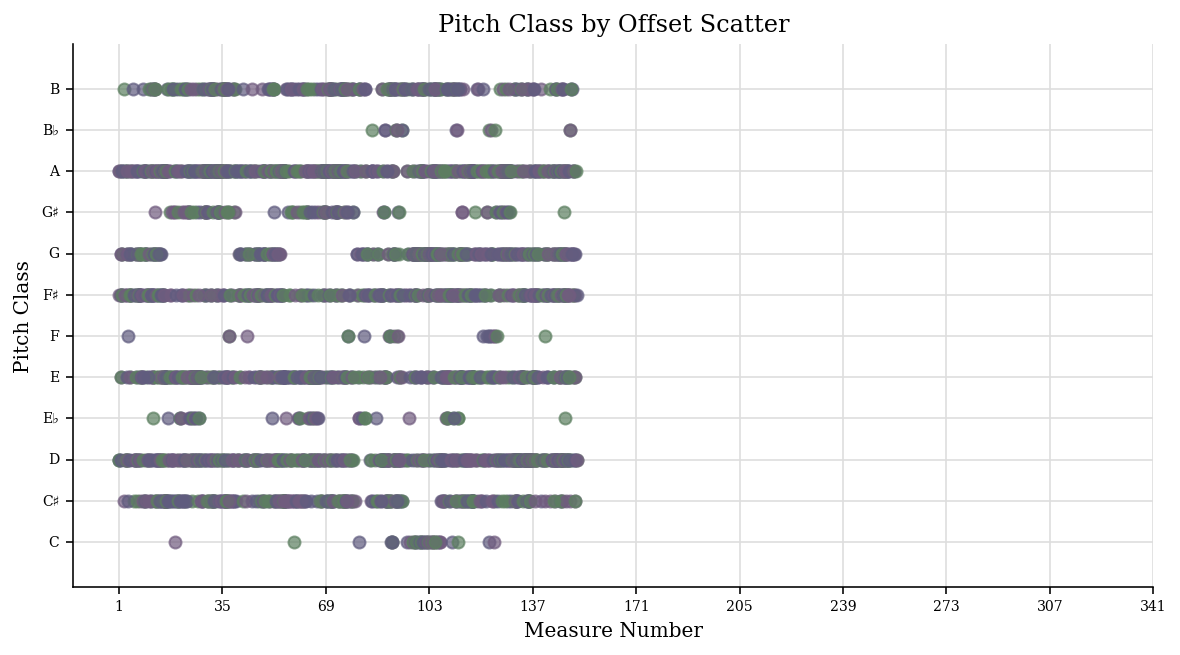

In [18]:
midi_file.plot('scatter', 'offset', 'pitchClass') 

# measure number 가 69부터 음악의 화음이 많아짐

음악 구성 확인

In [23]:
timeSignature = midi_file.getTimeSignatures()[0]
music_analysis = midi_file.analyze('key')
print("박자 : {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("음악 키: {0}".format(music_analysis))
print("키가 맞을 확률: {0}".format(music_analysis.correlationCoefficient))
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.7):
        print(analysis)
        
### 대체로 높은 음임을 알수있음

박자 : 4/4
음악 키: D major
키가 맞을 확률: 0.9540833637454167
A major
b minor


모차르트의 노래로 학습하면 밝은 음악을 만들 수 있지 않을까?

In [ ]:
# 모차르트의 음악들의 음을 찾아보자

In [43]:
def concat_path(path, child):
    return path + "/" + child

def process_single_file(midi_param):
    try:
        game_name = midi_param[0]
        midi_path = midi_param[1]
        midi_name = get_file_name(midi_path)
        midi = open_midi(midi_path, True)
        return (
            midi.analyze('key'),
            game_name,
            harmonic_reduction(midi),
            midi_name)
    except Exception as e:
        print("Error on {0}".format(midi_name))
        print(e)
        return None
def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
        
    return bass_note
                
def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret

def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
        
        # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        
        # Convert the chord to the functional roman representation
        # to make its information independent of the music key.
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
        
    return ret

In [49]:
key_signature_column = []
harmonic_reduction_column = []
midi_name_column = []

for file in os.listdir('mozart'):
    midi_name_column.append(file)
    
    midifile = open_midi(concat_path('mozart', file), True)
    try:
        key_signature_column.append(midifile.analyze('key'))
        harmonic_reduction_column.append(harmonic_reduction(midifile))
    except:
        print('no pitches')

d = {'midi_name': midi_name_column,
     'composer' : 'mozart',
         'key_signature' : key_signature_column,
         'harmonic_reduction': harmonic_reduction_column}
    
df_mozart = pd.DataFrame(data=d)

In [50]:
df_mozart

,midi_name,composer,key_signature,harmonic_reduction
0,mz_311_1.mid,mozart,D major,"[ii42, I6, I, ii42, I6, I, iv43, ii, V7, vi, I..."
1,mz_311_2.mid,mozart,G major,"[I, iv, vi43, I, I, V65, iv, I53, V42, vi53, V..."
2,mz_311_3.mid,mozart,D major,"[I, #iv65, iv, V53, I, iv43, IV7, iv7, V53, #i..."
3,mz_330_1.mid,mozart,C major,"[I53, I, I53, I, IV64, I53, I64, i, iv, I, iii..."
4,mz_330_2.mid,mozart,F major,"[v, I53, vi7, IV, V53, II65, V6, vi, V, I53, v..."
5,mz_330_3.mid,mozart,C major,"[iii65, V53, I6, V7, I, vi43, I, V53, I42, I42..."
6,mz_331_1.mid,mozart,A major,"[I53, V65, V, I64, iii, V65, I, I53, I53, v43,..."
7,mz_331_2.mid,mozart,A major,"[i, I, vi6, bv, iii42, v43, vi65, bVII42, ii, ..."
8,mz_331_3.mid,mozart,A major,"[vii, bIII7, biii, i65, i6, v, v, bV, i43, bII..."
9,mz_332_1.mid,mozart,F major,"[I6, iii6, ii6, vii, vi64, iii42, vi64, V, IV5..."


<AxesSubplot:title={'center':'All MOZART Key Signatures'}>

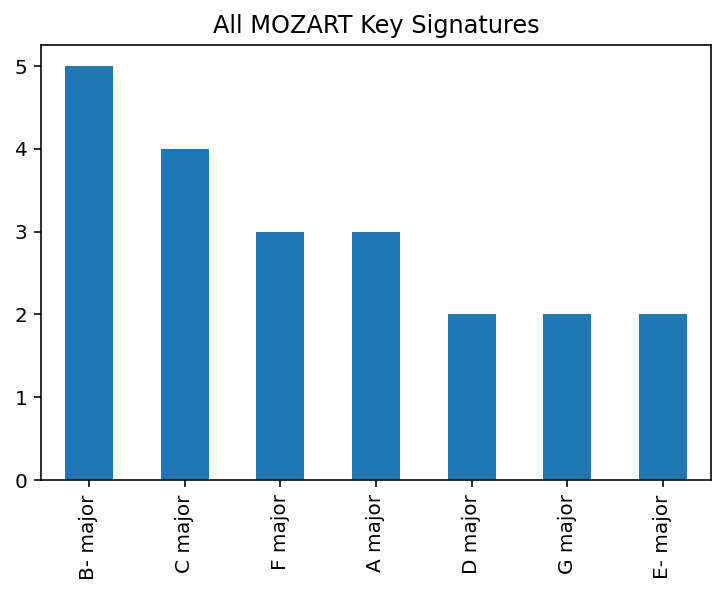

In [66]:
import matplotlib.pyplot as plt


df_mozart["key_signature"].value_counts().plot(kind='bar', title = "All MOZART Key Signatures")

major 음은 대체로 밝은 느낌을 준다 ===> 모차르트의 음악은 대체로 밝은 느낌이다

# training music

In [25]:
import glob
import pickle
import numpy as np
from music21 import converter, instrument, note, chord, stream 
from keras.models import Sequential

from keras.layers import CuDNNLSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm

from keras.callbacks import ModelCheckpoint

from keras.utils import np_utils

In [26]:
notes = []

for i, file in enumerate(glob.glob("mozart/*.mid")):
    midi = converter.parse(file)   
    print('\r', 'Parsing file ', i, " ",file, end='') # 현재 진행 상황 출력
    
    notes_to_parse = None
    notes_to_parse = midi.flat.notes
        
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

with open('data/notes', 'wb') as filepath:
    pickle.dump(notes, filepath)


C:\Users\medici\Anaconda3\lib\site-packages\music21\midi\translate.py:883: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


 Parsing file  2   mozart\mz_311_3.mid

C:\Users\medici\Anaconda3\lib\site-packages\music21\midi\translate.py:883: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


 Parsing file  5   mozart\mz_330_3.mid

C:\Users\medici\Anaconda3\lib\site-packages\music21\midi\translate.py:883: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2005 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


 Parsing file  14   mozart\mz_333_3.mid

C:\Users\medici\Anaconda3\lib\site-packages\music21\midi\translate.py:883: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


 Parsing file  20   mozart\mz_570_3.mid

In [3]:
n_vocab = (len(set(notes)))

pitchnames = sorted(set(item for item in notes))

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

In [4]:
sequence_length = 100

    # get all pitch names
pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

network_input = []
network_output = []

    # create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
network_input = network_input / float(n_vocab)

network_output = np_utils.to_categorical(network_output)


In [5]:
np.shape(network_input)

(302218, 100, 1)

In [6]:
model = Sequential()
model.add(CuDNNLSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
model.add(CuDNNLSTM(512, return_sequences=True))
model.add(CuDNNLSTM(512))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [16]:
   """ train the neural network """
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
)
callbacks_list = [checkpoint]

model.fit(network_input, network_output, epochs=100, batch_size=128, callbacks=callbacks_list)

Epoch 1/100
2362/2362 [==============================] - 156s 66ms/step - loss: 2.4176
Epoch 2/100
2362/2362 [==============================] - 155s 66ms/step - loss: 2.3503
Epoch 3/100
2362/2362 [==============================] - 155s 66ms/step - loss: 2.3010
Epoch 4/100
2362/2362 [==============================] - 155s 66ms/step - loss: 2.3366
Epoch 5/100
2362/2362 [==============================] - 156s 66ms/step - loss: 2.3948
Epoch 6/100
2362/2362 [==============================] - 155s 66ms/step - loss: 3.0452
Epoch 7/100
2362/2362 [==============================] - 156s 66ms/step - loss: 4.6233
Epoch 8/100
2362/2362 [==============================] - 155s 66ms/step - loss: 3.9098
Epoch 9/100
2362/2362 [==============================] - 156s 66ms/step - loss: 2.3863
Epoch 10/100
 176/2362 [=>............................] - ETA: 2:23 - loss: 2.2248

KeyboardInterrupt: 

In [10]:
model.save('MozertLSTM.h5')

In [11]:
del model

### 작곡 시작

In [12]:
from keras.models import load_model
model = load_model('MozertLSTM.h5')

In [13]:
network_input = []
network_output = []

    # create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
network_input = network_input / float(n_vocab)

network_output = np_utils.to_categorical(network_output)


In [14]:
start = np.random.randint(0, len(network_input)-1)

int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

pattern = network_input[start]
prediction_output = []

    # generate 500 notes
for note_index in range(500):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)

    prediction = model.predict(prediction_input, verbose=0)

    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)

    pattern = np.append(pattern,index)
    pattern = pattern[1:len(pattern)]

In [15]:
print('length of pred_out : ', len(prediction_output))
print('pred_out : ', prediction_output)

length of pred_out :  500
pred_out :  ['0.3', 'E-5', 'E-5', 'C5', 'C5', 'E-4', 'E-4', 'E-4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'B3', 'B3', 'B3', 'C3', 'C3', 'C3', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C5', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C3', 'C3', 'C5', 'C6', 'C5', 'C2', 'C5', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', '

In [23]:
offset = 0
output_notes = []

    # create note and chord objects based on the values generated by the model
for pattern in prediction_output:
        # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
        # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
    offset += 0.5

midi_stream = stream.Stream(output_notes)

midi_stream.write('midi', fp='lstm_all.mid')

'test_output5.mid'

생성된 음악 EDA

In [36]:
def open_midi(midi_path, remove_drums):
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
midi_file = open_midi(r"C:\Users\medici\Desktop\lstm music\mozart\test_output.mid", True)
midi_file

<music21.stream.Score 0x1732bb49760>

In [37]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(midi_file)

# 피아노 한개의 음악

None


<music21.graph.plot.HistogramPitchClass for <music21.stream.Score 0x1732bb49760>>

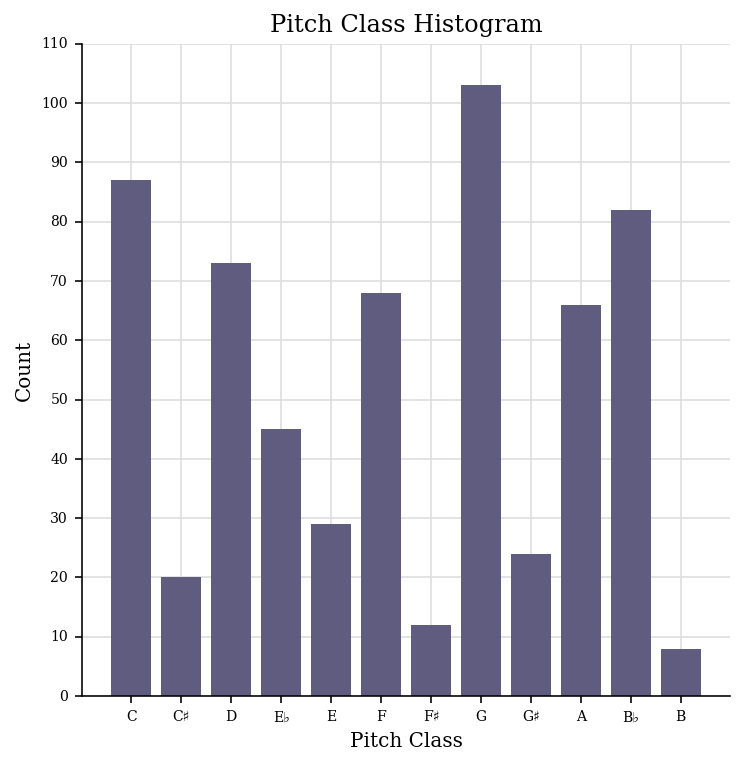

In [38]:
midi_file.plot('histogram', 'pitchClass', 'count')

<music21.graph.plot.ScatterPitchClassOffset for <music21.stream.Score 0x1732bb49760>>

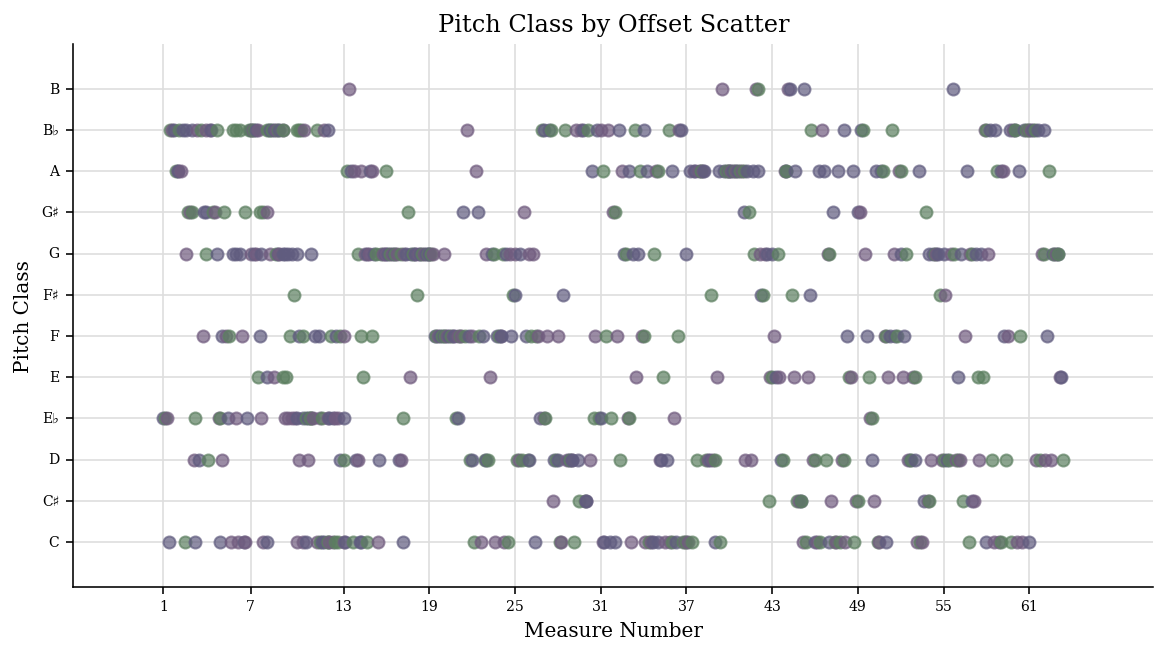

In [39]:
midi_file.plot('scatter', 'offset', 'pitchClass') 

In [40]:
timeSignature = midi_file.getTimeSignatures()[0]
music_analysis = midi_file.analyze('key')
print("박자 : {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("음악 키: {0}".format(music_analysis))
print("키가 맞을 확률: {0}".format(music_analysis.correlationCoefficient))
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.7):
        print(analysis)
        
### 대체로 높은 음임을 알수있음

박자 : 4/4
음악 키: g minor
키가 맞을 확률: 0.9092048460603661
F major
c minor
B- major
